In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.datasets import make_moons


### 1. Generate 2D Two-Moons Data

This section uses sklearn.datasets.make_moons to generate a 2D synthetic dataset commonly used for testing classification and generative models.

The output X is a tensor holding the 2D coordinates of the datapoints, with a shape of (2000,2), where each row represents a point (x,y).

A small amount of noise (0.05) is added to make the moons less perfectly shaped and more realistic.

The data is generated as a NumPy array and then converted into a PyTorch tensor (torch.float32) for use in the neural network.

A scatter plot visualizes the initial, clean dataset X_0
​


In [12]:
# 1. GENERATE 2D two-moons data

#2000 rows
n_samples = 2000
X, _ = make_moons(n_samples=n_samples, noise=0.05)
X = torch.tensor(X, dtype=torch.float32)


### 2. Define Diffusion Schedule

The diffusion schedule defines the hyperparameters for incrementally adding noise over T=200 steps.

T: The total number of diffusion steps (an integer scalar).

β (Noise Schedule): A (T,) tensor representing the variance of the Gaussian noise added at each step. Values are linearly spaced from 10 
−4
  to 0.02. This results in smaller noise being added at the start and larger noise near the end.

α: A (T,) tensor calculated as 1−β. It controls the portion of the previous signal retained at each step.

α_bar
  (Cumulative Product): The cumulative product of α. This is the core DDPM schedule, providing a closed-form solution to determine how much of the original clean sample (x 
0
​
 ) remains after t noising steps. It is a (T,) tensor.

In [13]:
T = 200  # number of diffusion steps
beta = torch.linspace(1e-4, 0.02, T)  # noise schedule  ##1
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0) 

### 3. Define Simple Denoising Model
The DenoiseMLP is a simple PyTorch neural network built to predict the noise ϵ in the data x_t at a given timestep t. It inherits functionality by calling the parent constructor.

#### Architecture
The network consists of three linear layers designed to process and predict the 2D data:

self.fc1: The input layer takes an input size of 3 (the 2D coordinates x 
t
​
  plus 1 time embedding) and outputs 128 features. The weights are shaped (128,3).

self.fc2: This hidden layer maps 128 input features to 128 output features.

self.fc3: The final layer takes 128 features and outputs 2D coordinates, which is the predicted noise vector ϵ_θ
​
 .

#### Forward Pass Logic
The forward(self, x, t) method processes a batch of size N, where x is the noised data (shape: (N,2)) and t is the timestep batch (shape: (N,)).

Time Embedding: The timestep t is first normalized by T (since T=200). It is then given a feature dimension using t.unsqueeze(-1), resulting in a time embedding t 
embed
​
  of shape (N,1).

Concatenation: x and t 
embed
​
  are concatenated along the feature dimension (dim=1). This combined input h has a shape of (N,3), merging the spatial and time features.

Propagation: h is passed through self.fc1 (mapping to 128 features), with a ReLU non-linearity applied. The result is passed through self.fc2 (mapping 128 to 128 features), with another ReLU applied.

Output: Finally, self.fc3 generates the output. The returned tensor has a shape of (N,2), representing the predicted noise vector for each input point.

In [14]:
class DenoiseMLP(nn.Module):
    def __init__(self):
        
        super().__init__()
        #first layer takes in 2d coords + 1 time embedding
        self.fc1 = nn.Linear(2+1, 128)  # +1 for time embedding
        #hidden, second linear layer
        self.fc2 = nn.Linear(128, 128)
        #final layer takes in 128 features, outputs 2d coords (the predicted noise)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x, t):

        t = t / T

        t_embed = t.unsqueeze(-1)

        h = torch.cat([x, t_embed], dim=1)

        h = F.relu(self.fc1(h))

        h = F.relu(self.fc2(h))

        return self.fc3(h)

Instantiate model and optimizer
#Adam optimizer will update all model.parameters() with learning rate 1e-3.

In [15]:

# Instantiate model and optimizer
model = DenoiseMLP()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 4. TRAINING LOOP

# epochs: total number of times the entire dataset is passed through the model

# batch size = number of samples processed in one forward/backward pass (before the models paramters are updated during training)
# a sample is a single data point (2d coord here)
#batch_size = 128

In [16]:

n_epochs = 2000

batch_size = 2000

In [17]:
#loop over the epochs, aka repeat trainig process 2000 times
for epoch in range(n_epochs):
    # Sample random batch of data
    #
    idx = torch.randint(0, n_samples, (batch_size,))
    # x0 is the clean data for this batch, shape (batch_size, 2) - 128 points each with 2 features (x,y)
    #essentially: a tesnor of shape (128, 2)
    x0 = X[idx]
    
    # Sample random timestep
    # sample a random timestep for each point/sample in the batch
    t = torch.randint(0, T, (batch_size,))
    

    # Forward diffusion q(x_t | x_0)

    # this makes random gaussian noise with the same shape as x0, so (128,2)
    # each row is noise sampled from a normal distribution
    #this is the true noise that the model will try to predict later
    noise = torch.randn_like(x0)
    # alpha_bar is precomputed (200,) tensor - one value per timestep
    #t is (128,), so alpha_bar[t] is (128,) - one value per sample in the batc
    #it picks the value for each sample's timestep t
    #unsqueeze(-1) makes it (128,1) so we can broadcast in the next step
    alpha_bar_t = alpha_bar[t].unsqueeze(-1)
    # THIS IS THE FORWARD DIFFUSION EQUATION
    # x_t is the noised version of x0 at timestep t
    # At small t, noise is small, at large t, noise is larg
    x_t = torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*noise
    
    # Predict noise
    # feed the noised sample x_t and its timestep t
    # model tries to guess the exact noise that was added to x0 to get x_t
    # x_t is (128,2), t.float() is (128,) - one
    #noise_pred is (128,2) - the model's predicted noise for each sample
    noise_pred = model(x_t, t.float())
    
    # Compute loss (MSE between true noise and predicted noise
    # the closer loss is to 0, the better the model is at predicting the noise added at each step
    # loss is a scalar tensor
    loss = F.mse_loss(noise_pred, noise)

    #stopped here again
    # clears old gradients
    optimizer.zero_grad()
    #computes newe gradients of loss with respect to all the weights using backprop
    loss.backward()
    # updates weights with gradient descent (adam is a gradient descent? variant)
    optimizer.step()



# 5. SAMPLING FROM LEARNED MODEL


# time to generate new data after training
#tell pytorch not to track gradients, cause we don't need the gradient history since
# we are not training anymore

#define a function that samples n_samples 
#start from pure gaussian noise
# shape is (n_samples, 2) since our data is 2d two-moons



...
    
    #finally, return the generated samples after all timesteps
    # x should now be a (n_samples, 2) tensor of generated 2d points that look like the two-moons data even though they started as pure noise

In [18]:
@torch.no_grad()
def sample(model, n_samples):
    x = torch.randn(n_samples, 2)  # start from pure noise
    #loop over timesteps in reverse order
    for t in reversed(range(T)):
        # Create a 1-D tesnor of length n_samples, where all entries == current timestep t
        # this is needed because the model expects a batch of timesteps, one per sample
        #the shape is (n_samples, )
        t_batch = torch.full((n_samples,), t, dtype=torch.float32)
        # calls the denoiser model to predict the noise in x at timestep t
        # x is (n_samples, 2), t_batch is (n_samples,)
        predicted_noise = model(x, t_batch)
        #the following 3 lines index the precomputed schedules to get the scalar values for the current timestep t
        # alpha_t represents the portion of the original data retained at step t
        alpha_t = alpha[t]
        # alpha_bar_t represents the total portion of original data retained up to step t (cumulative product)
        alpha_bar_t = alpha_bar[t]
        # beta_t represents the variance of the noise added at step t
        beta_t = beta[t]
        
        # Reverse diffusion step IMPORTANT
        # this equation is the algebraic reverse step that tries to recover x_{t-1} from x_t - computes the posterior mean estimate
        # It uses the model's predicted noise to subtract out the noise component from x
        #first multiplies x by 1/sqrt(alpha_t) to scale it up to undo the forward step shrink
        x = 1/torch.sqrt(alpha_t) * (x - (1-alpha_t)/torch.sqrt(1-alpha_bar_t)*predicted_noise)
        # Add noise except for the last step (last step t=0 should be clean)
        # torch.randn_like(x) makes gaussian noise of shape (n_samples, 2)
        # scaled by sqrt(beta_t) to control the amount of noise added back in 
        # (we want to add a small amount of noise back in at each step to maintain stochasticity so outputs are diverse) 
        #   REVERSE PROCESS IS STOCHASTIC, NOT DETERMINISTIC
        if t > 0:
            x += torch.sqrt(beta_t) * torch.randn_like(x) ###

        if t in [199, 150, 100, 50, 40, 30, 20, 15, 10, 5, 0]:
            #plt.scatter(x[:,0], x[:,1], s=2)
            #plt.title(f"Generated Data at Timestep {t}")
            #plt.savefig(f"generated_data_t{t}.png", dpi=300)
            #plt.close()
            plt.figure(figsize=(8,6))
            plt.hist2d(x[:,0].numpy(), x[:,1].numpy(), bins=100, density=True, cmap='viridis')
            plt.colorbar(label='Density')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f"Generated Data at Timestep {t}")
            plt.savefig(f"generated_data_t{t}.png", dpi=300)


    return x

One sample from generated data: tensor([[1.0791, 0.6514]])


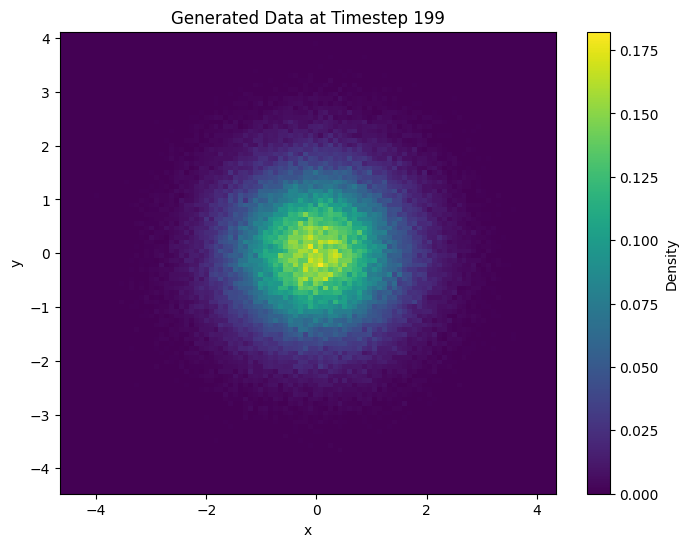

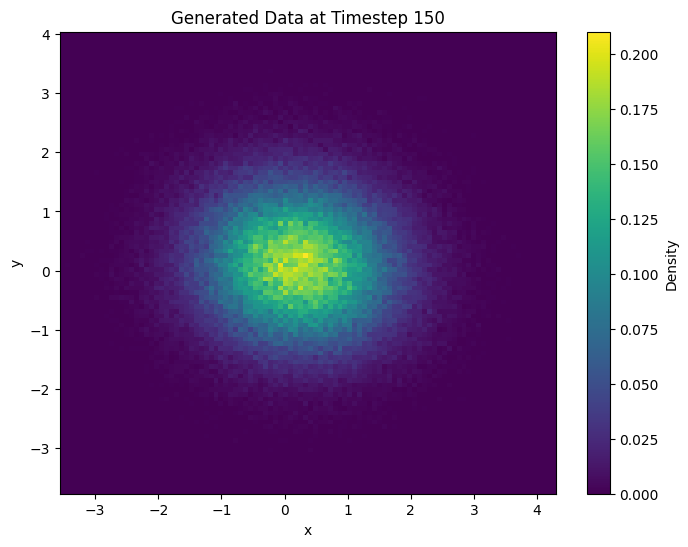

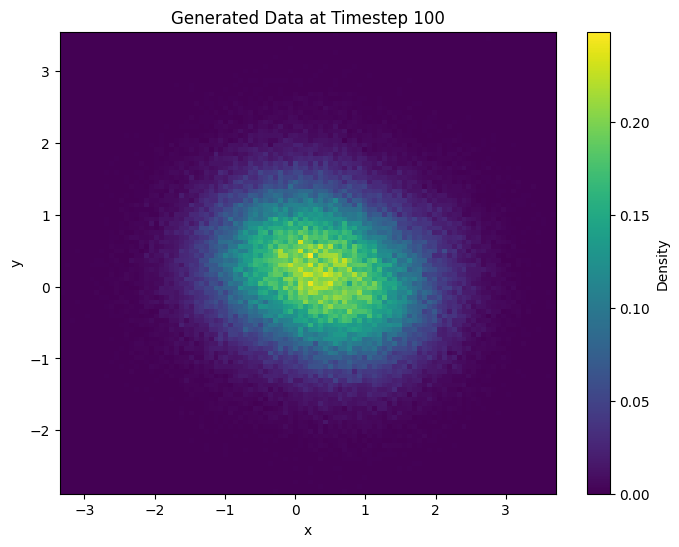

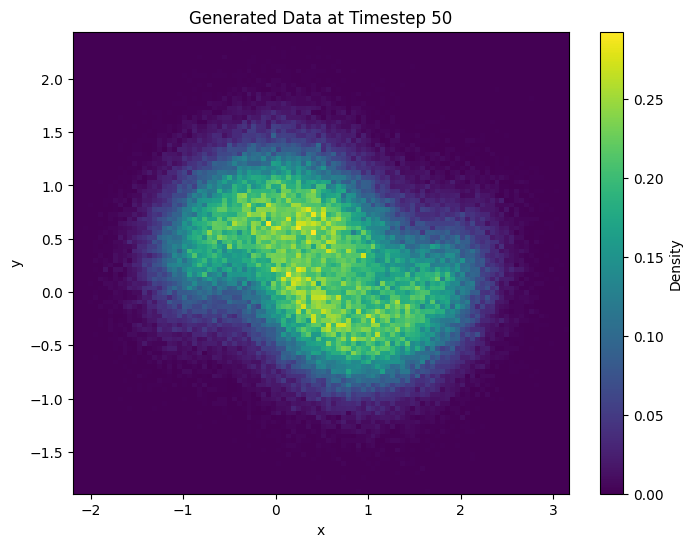

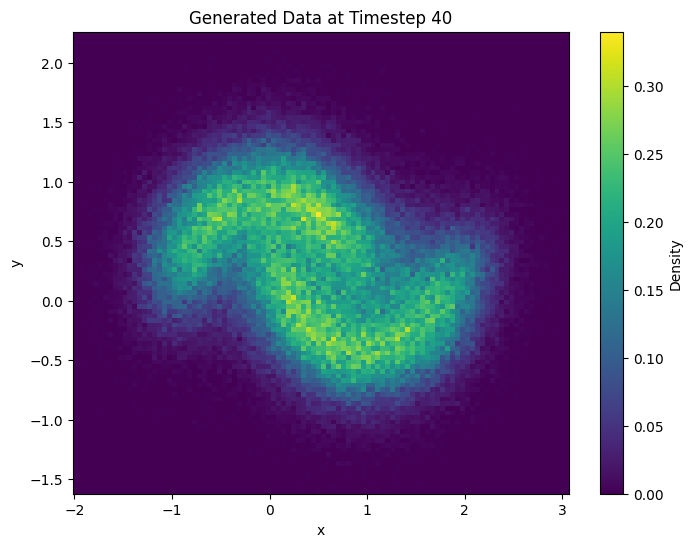

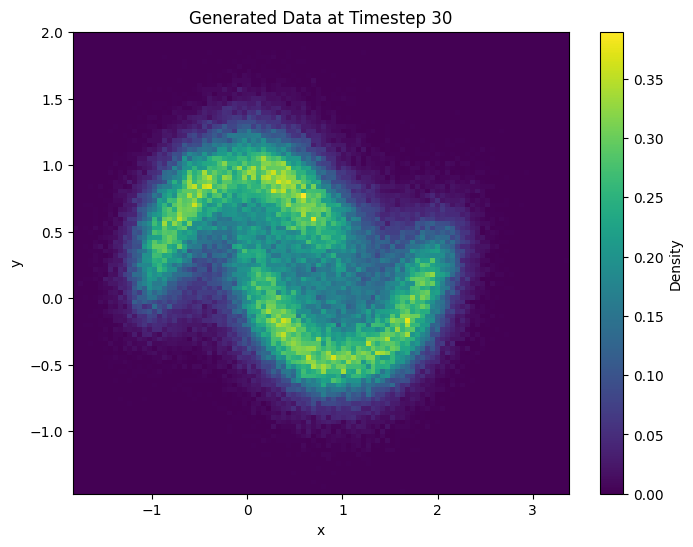

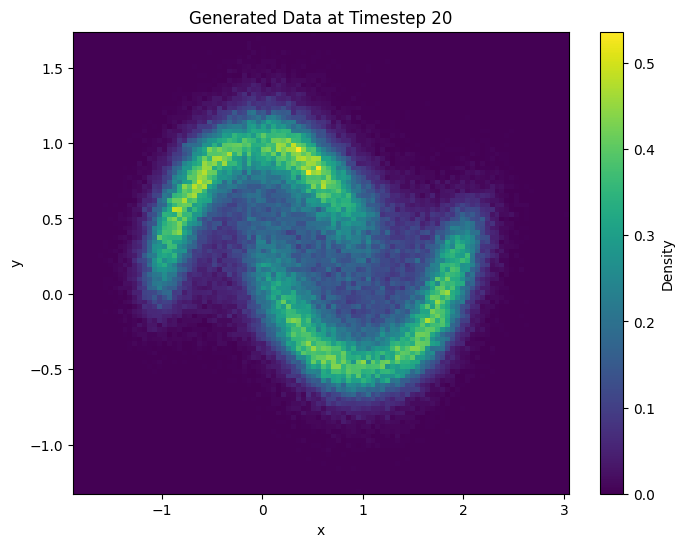

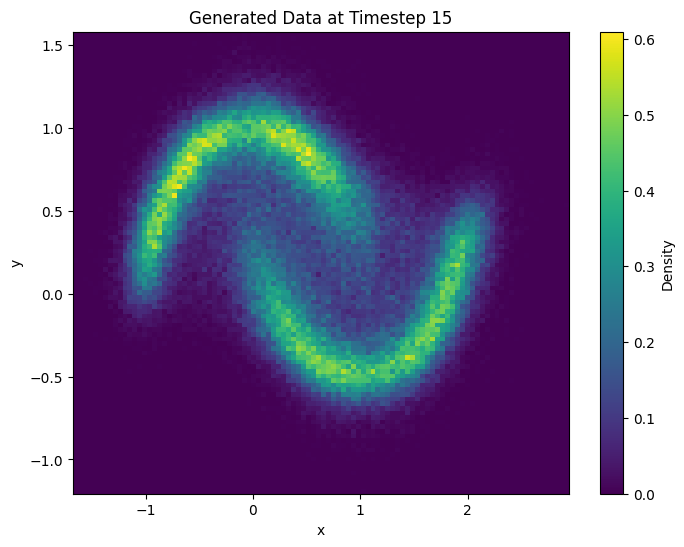

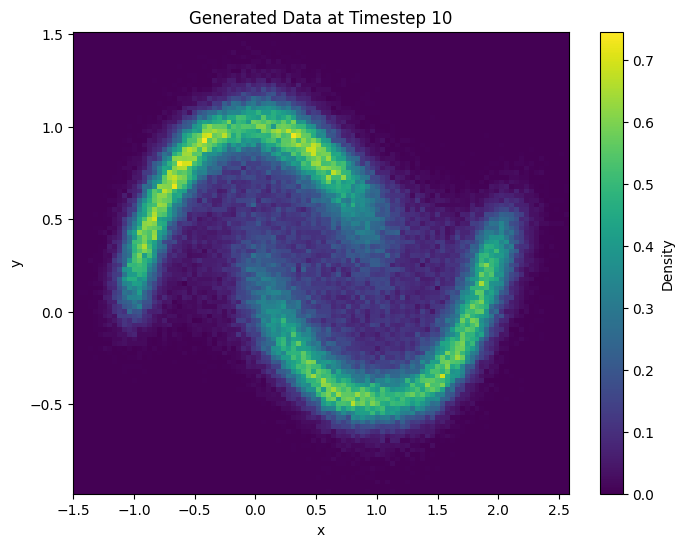

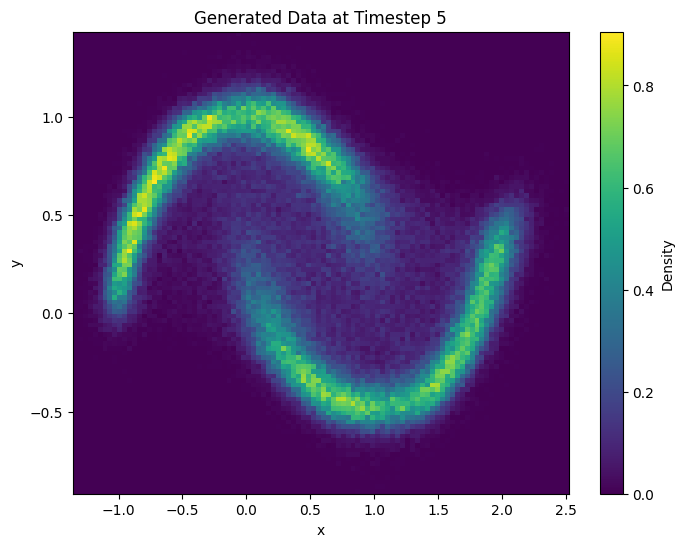

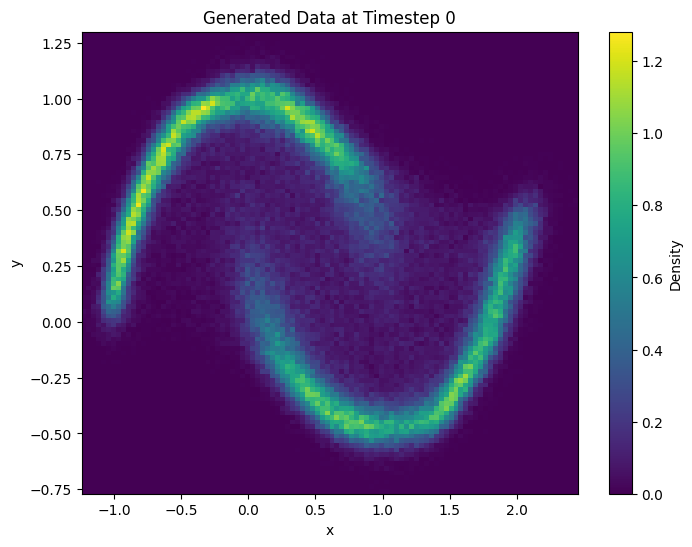

In [19]:

# # Generate samples
samples = sample(model, 200000)

# # 6. Print one random sample

print("One sample from generated data:", samples[torch.randint(0, samples.shape[0], (1,))])


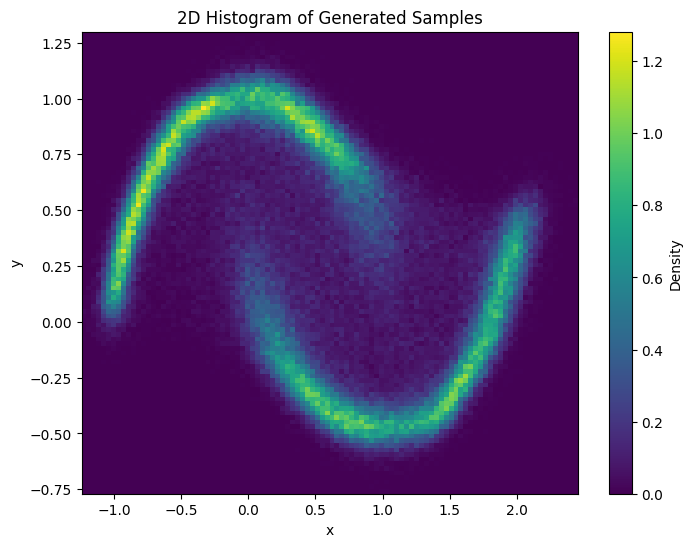

In [20]:
# 7. 2D histogram

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

plt.figure(figsize=(8,6))
plt.hist2d(samples[:,0].numpy(), samples[:,1].numpy(), bins=100, density=True, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Histogram of Generated Samples')
plt.savefig(f"two_moons_hist_{timestamp}.png", dpi=300)